In [248]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel, InducedOperatorModel, build_batched_jac_func
from EquationModel import CholInducedRKHS, OperatorPDEModel
from jax.scipy.linalg import block_diag
from jax.scipy.linalg import solve
from scipy.interpolate import RectBivariateSpline
from pde_solvers.BurgerSolver import get_burger_solver
from parabolic_data_utils import build_tx_grid

In [249]:
class KS_ETDRK2():
    def __init__(
        self,
        L,
        N,
        dt,
    ):
        self.L = L
        self.N = N
        self.dt = dt
        self.dx = L / N

        wavenumbers = jnp.fft.rfftfreq(N, d=L / (N * 2 * jnp.pi))
        self.derivative_operator = 1j * wavenumbers

        linear_operator = - self.derivative_operator**2 - self.derivative_operator**4
        self.exp_term = jnp.exp(dt * linear_operator)
        self.coef_1 = jnp.where(
            linear_operator == 0.0,
            dt,
            (self.exp_term - 1.0) / linear_operator,
        )
        self.coef_2 = jnp.where(
            linear_operator == 0.0,
            dt / 2,
            (self.exp_term - 1.0 - linear_operator * dt) / (linear_operator**2 * dt)
        )

        self.alias_mask = (wavenumbers < 2/3 * jnp.max(wavenumbers))
        
    def __call__(
        self,
        u,
    ):
        u_nonlin = - 0.5 * u**2
        u_hat = jnp.fft.rfft(u)
        u_nonlin_hat = jnp.fft.rfft(u_nonlin)
        u_nonlin_hat = self.alias_mask * u_nonlin_hat
        u_nonlin_der_hat = self.derivative_operator * u_nonlin_hat

        u_stage_1_hat = self.exp_term * u_hat + self.coef_1 * u_nonlin_der_hat
        u_stage_1 = jnp.fft.irfft(u_stage_1_hat, n=self.N)

        u_stage_1_nonlin = - 0.5 * u_stage_1**2
        u_stage_1_nonlin_hat = jnp.fft.rfft(u_stage_1_nonlin)
        u_stage_1_nonlin_hat = self.alias_mask * u_stage_1_nonlin_hat
        u_stage_1_nonlin_der_hat = self.derivative_operator * u_stage_1_nonlin_hat

        u_next_hat = u_stage_1_hat + self.coef_2 * (u_stage_1_nonlin_der_hat - u_nonlin_der_hat)
        u_next = jnp.fft.irfft(u_next_hat, n=self.N)

        return u_next

In [266]:
DOMAIN_SIZE = 100.0
N_discrete = 2000 
DT = 0.01 
final_time = 50


mesh = jnp.linspace(0.0, DOMAIN_SIZE, N_discrete, endpoint=False)
# u_0 = (
#     0.3*jnp.sin(2*jnp.pi*mesh/DOMAIN_SIZE)+
#     jnp.sin(12 * jnp.pi * mesh / DOMAIN_SIZE) + 
#     jnp.cos(2*jnp.pi*mesh/DOMAIN_SIZE)
# )

u_0 = jnp.sin(2 * jnp.pi * mesh / DOMAIN_SIZE)

ks_stepper_etdrk2 = KS_ETDRK2(
    L=DOMAIN_SIZE,
    N=N_discrete,
    dt=DT,
)

In [267]:
ks_stepper_etdrk2 = jax.jit(ks_stepper_etdrk2)
u_current = u_0
trj_etdrk2 = [u_current, ]
t_vals = [0]
for i in tqdm(range(int(final_time//DT)+1)):
    u_current = ks_stepper_etdrk2(u_current)
    trj_etdrk2.append(u_current)
    t_vals.append(t_vals[-1]+DT)

trj_etdrk2 = jnp.stack(trj_etdrk2)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:00<00:00, 5453.48it/s]


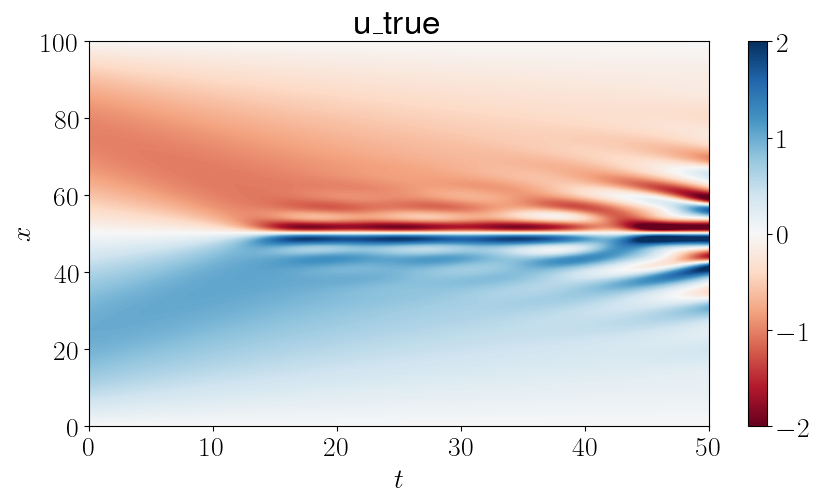

In [268]:
# u_true
plt.figure(figsize=(10, 5))
plt.title('u_true')
plt.imshow(
    trj_etdrk2.T,
    cmap="RdBu",
    aspect="auto",
    origin="lower",
    extent=(0, final_time, 0, DOMAIN_SIZE),
    vmin=-2,
    vmax=2,
)
plt.colorbar()
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.grid(False)
plt.show()

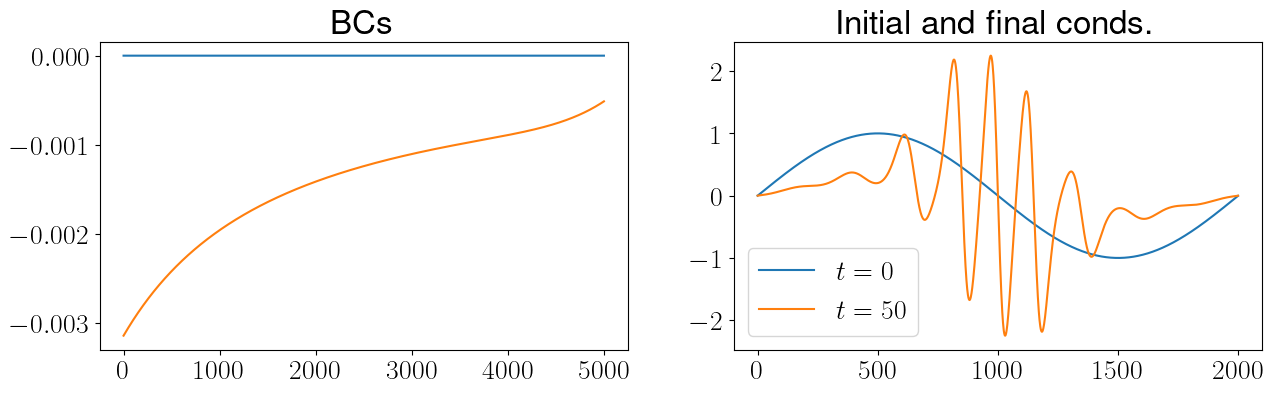

In [269]:
# plt.title('Periodic BCs')
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
plt.title('BCs')
plt.plot(trj_etdrk2[:,0])
plt.plot(trj_etdrk2[:,-1])
plt.subplot(1,2,2)
plt.title('Initial and final conds.')
plt.plot(trj_etdrk2[0,:], label= '$t=0$')
plt.plot(trj_etdrk2[-1,:], label= '$t = 50$')
plt.legend(loc= 'lower left')
plt.show()

In [270]:
tvals = jnp.array(t_vals)
grid = jnp.hstack([mesh, mesh[-1] + (mesh[-1] - mesh[-2])])
sols = jnp.hstack([trj_etdrk2,trj_etdrk2[:,-1:]])

t_range = jnp.array([tvals[0],tvals[-1]])
x_range = jnp.array([grid[0],grid[-1]])

interp = RectBivariateSpline(tvals,grid,sols,kx = 5,ky = 5)
ut_interp = interp.partial_derivative(1,0)

def u_true_function(x):
    return interp(x[:,0],x[:,1],grid = False)

def ut_true_function(x):
    return ut_interp(x[:,0],x[:,1],grid = False)

In [271]:
num_grid_x = 40
num_grid_t = 26
# num_grid_x = 50
# num_grid_t = 50

tx_int,tx_bdy = build_tx_grid(t_range,x_range,num_grid_t,num_grid_x)

tx_all = jnp.vstack([tx_bdy,tx_int])

init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
num_init_obs_inds = len(init_obs_inds)


u_true = u_true_function(tx_all)

num_obs = 600
np.random.seed(0)

remaining_inds = list(
    set(list(np.arange(len(tx_int)))) - 
    set(list(np.where(tx_int[:,0]==0)[0]))
)

x_t_sample_inds = np.random.choice(remaining_inds,num_obs,replace = False)
x_t_sample_inds = jnp.hstack([init_obs_inds,x_t_sample_inds])

tx_obs = jnp.vstack([tx_bdy,tx_int[x_t_sample_inds]])

u_obs = u_true_function(tx_obs)

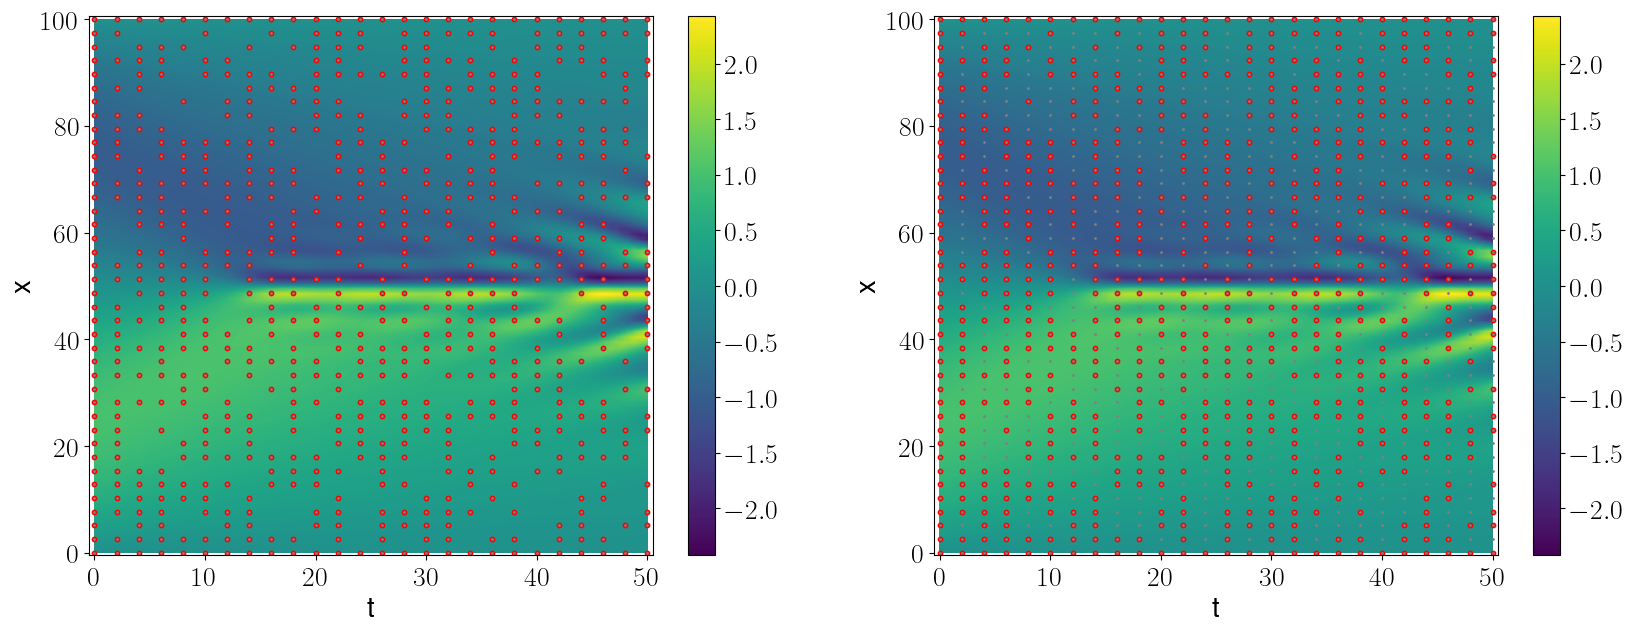

In [272]:
num_fine_grid = 100
final_time = 50
t_fine,x_fine = np.meshgrid(np.linspace(0,t_range[1],num_fine_grid),np.linspace(0,x_range[1],num_fine_grid))
tx_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),200)
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 10)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='gray',s = 1)

plt.xlim(t_range[0]-0.5,t_range[1]+0.5)
plt.ylim(x_range[0]-0.5,x_range[1]+0.5)
plt.xlabel("t")
plt.ylabel("x")
plt.subplot(1,2,2)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),200)
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 10)

plt.scatter(tx_all[:,0],tx_all[:,1],c='gray',s = 1)
plt.xlim(t_range[0]-0.5,t_range[1]+0.5)
plt.ylim(x_range[0]-0.5,x_range[1]+0.5)

plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [273]:
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel,get_anisotropic_gaussianRBF

def d4x_k(k,index):
    result = k
    for i in range(4):
        result = get_selected_grad(result,index,1)
    return result

feature_operators = tuple([eval_k,dx_k,dxx_k,d4x_k])


# ku_mat = jnp.diag(jnp.array([0.2,1.]))
# k_u = get_anisotropic_gaussianRBF(3,ku_mat)
#get_sum_of_kernels([get_gaussianRBF(0.05),get_gaussianRBF(0.2)],coefficients=[0.5,0.5])#get_gaussianRBF(0.1)
# Choose u kernel
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)
from Kernels import log1pexp,inv_log1pexp,fit_kernel_params
fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)
print(1/(jnp.sqrt(ML_lengthscales)))
k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(fitted_params)))


u_model = CholInducedRKHS(
    tx_all,
    feature_operators,
    k_u
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)
grid_features_init = jnp.hstack([tx_int,grid_features_init])

k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init[:,2:],c=1.,scaling = 'diagonal')

def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])

# class P_model():
#     kernel_function = jit(
#         get_kernel_block_ops(k_P,[eval_k],[eval_k])
#     )
#     num_params = len(grid_features_init)

#     @jit
#     def predict(input_data,params):
#         K = P_model.kernel_function(input_data,input_data)
#         return K@params

P_model = InducedOperatorModel(grid_features_init,k_P)
num_P_params = len(grid_features_init)

[3.75410732 2.31961225]


In [274]:
# Equation model that has u and P object
EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100,
    num_P_operator_params = num_P_params,
    # jacobian_operator = build_batched_jac_func(100),
)

In [275]:
import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM, LMParams
params_init = jnp.hstack([u_params_init,jnp.zeros(len(tx_int))])
optparams = LMParams(max_iter = 1001)

params,convergence_data = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    optParams = optparams
)

  0%|          | 1/1001 [00:28<7:50:33, 28.23s/it]

Iteration 0, loss = 0.002616, gradnorm = 0.06536, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/1001 [00:28<3:15:40, 11.75s/it]

Iteration 1, loss = 0.002479, gradnorm = 0.02517, alpha = 2.083, improvement_ratio = 1.0


  0%|          | 3/1001 [00:28<1:47:50,  6.48s/it]

Iteration 2, loss = 0.002375, gradnorm = 0.01711, alpha = 1.736, improvement_ratio = 1.0


  0%|          | 4/1001 [00:28<1:06:36,  4.01s/it]

Iteration 3, loss = 0.002285, gradnorm = 0.0141, alpha = 1.447, improvement_ratio = 1.0


  0%|          | 5/1001 [00:29<43:50,  2.64s/it]  

Iteration 4, loss = 0.002207, gradnorm = 0.01202, alpha = 1.206, improvement_ratio = 1.0


  1%|          | 6/1001 [00:29<30:06,  1.82s/it]

Iteration 5, loss = 0.002141, gradnorm = 0.01019, alpha = 1.005, improvement_ratio = 1.0


  5%|▌         | 51/1001 [00:38<03:23,  4.67it/s]

Iteration 50, loss = 0.0006614, gradnorm = 0.0004691, alpha = 0.0002747, improvement_ratio = 1.007


 10%|█         | 101/1001 [00:49<03:12,  4.67it/s]

Iteration 100, loss = 1.133e-07, gradnorm = 5.376e-05, alpha = 3.019e-08, improvement_ratio = 0.9876


 15%|█▌        | 151/1001 [01:00<03:02,  4.67it/s]

Iteration 150, loss = 9.499e-09, gradnorm = 4.53e-08, alpha = 8.333e-09, improvement_ratio = 1.0


 20%|██        | 201/1001 [01:11<02:51,  4.67it/s]

Iteration 200, loss = 8.83e-09, gradnorm = 4.516e-08, alpha = 8.333e-09, improvement_ratio = 1.001


 25%|██▌       | 251/1001 [01:21<02:40,  4.67it/s]

Iteration 250, loss = 8.545e-09, gradnorm = 3.698e-08, alpha = 8.333e-09, improvement_ratio = 1.001


 30%|███       | 301/1001 [01:32<02:29,  4.67it/s]

Iteration 300, loss = 8.363e-09, gradnorm = 3.946e-08, alpha = 8.333e-09, improvement_ratio = 1.0


 35%|███▌      | 351/1001 [01:43<02:19,  4.67it/s]

Iteration 350, loss = 8.226e-09, gradnorm = 4.231e-08, alpha = 8.333e-09, improvement_ratio = 1.0


 40%|████      | 401/1001 [01:53<02:08,  4.67it/s]

Iteration 400, loss = 8.114e-09, gradnorm = 4.241e-08, alpha = 8.333e-09, improvement_ratio = 1.0


 45%|████▌     | 451/1001 [02:04<01:57,  4.67it/s]

Iteration 450, loss = 8.019e-09, gradnorm = 4.038e-08, alpha = 8.333e-09, improvement_ratio = 1.0


 50%|█████     | 501/1001 [02:15<01:47,  4.67it/s]

Iteration 500, loss = 7.934e-09, gradnorm = 3.732e-08, alpha = 8.333e-09, improvement_ratio = 1.0


 55%|█████▌    | 551/1001 [02:25<01:36,  4.67it/s]

Iteration 550, loss = 7.858e-09, gradnorm = 3.396e-08, alpha = 8.333e-09, improvement_ratio = 1.0


 60%|██████    | 601/1001 [02:36<01:25,  4.66it/s]

Iteration 600, loss = 7.788e-09, gradnorm = 3.071e-08, alpha = 8.333e-09, improvement_ratio = 1.0


 65%|██████▌   | 651/1001 [02:47<01:15,  4.66it/s]

Iteration 650, loss = 7.724e-09, gradnorm = 2.774e-08, alpha = 8.333e-09, improvement_ratio = 1.0


 70%|███████   | 701/1001 [02:58<01:04,  4.67it/s]

Iteration 700, loss = 7.663e-09, gradnorm = 2.51e-08, alpha = 8.333e-09, improvement_ratio = 1.0


 75%|███████▌  | 751/1001 [03:08<00:53,  4.67it/s]

Iteration 750, loss = 7.606e-09, gradnorm = 2.278e-08, alpha = 8.333e-09, improvement_ratio = 1.0


 80%|████████  | 801/1001 [03:21<00:42,  4.66it/s]

Iteration 800, loss = 7.553e-09, gradnorm = 2.074e-08, alpha = 8.333e-09, improvement_ratio = 1.0


 85%|████████▌ | 851/1001 [03:31<00:32,  4.67it/s]

Iteration 850, loss = 7.504e-09, gradnorm = 1.894e-08, alpha = 8.333e-09, improvement_ratio = 1.0


 90%|█████████ | 901/1001 [03:42<00:21,  4.67it/s]

Iteration 900, loss = 7.459e-09, gradnorm = 1.732e-08, alpha = 8.333e-09, improvement_ratio = 1.0


 95%|█████████▌| 951/1001 [03:53<00:10,  4.67it/s]

Iteration 950, loss = 7.418e-09, gradnorm = 1.589e-08, alpha = 8.333e-09, improvement_ratio = 1.0


100%|██████████| 1001/1001 [04:04<00:00,  4.10it/s]

Iteration 1000, loss = 7.38e-09, gradnorm = 1.46e-08, alpha = 8.333e-09, improvement_ratio = 1.0


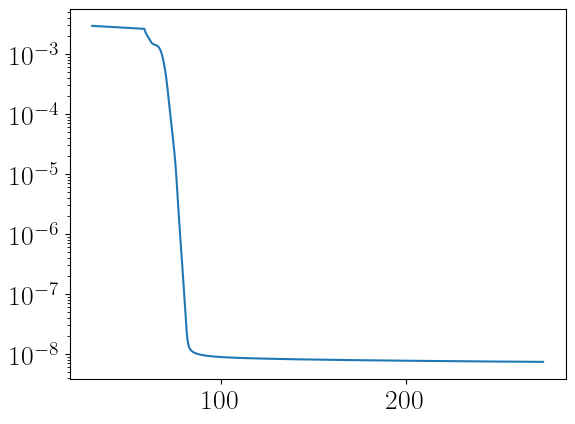

In [276]:
plt.plot(convergence_data.cumulative_time,convergence_data.loss_vals)
plt.yscale('log')

In [277]:
u_sol = params[:u_model.num_params]
P_sol = params[u_model.num_params:]

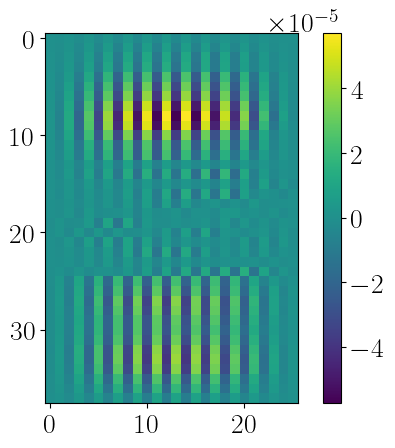

In [278]:
equation_residuals = EqnModel.stacked_equation_residual((u_sol,),P_sol)
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t))
plt.grid(False)
plt.colorbar()
plt.show()

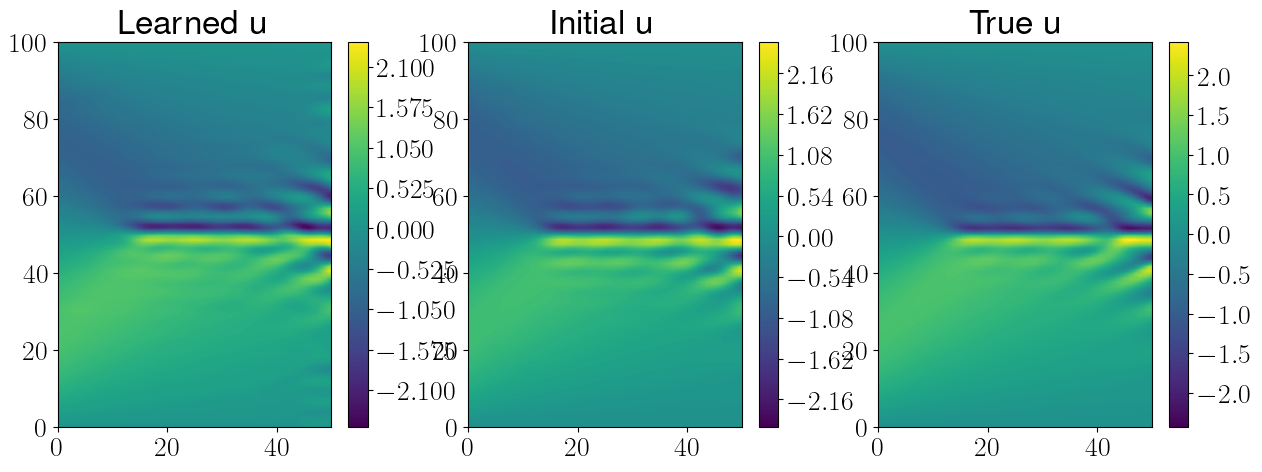

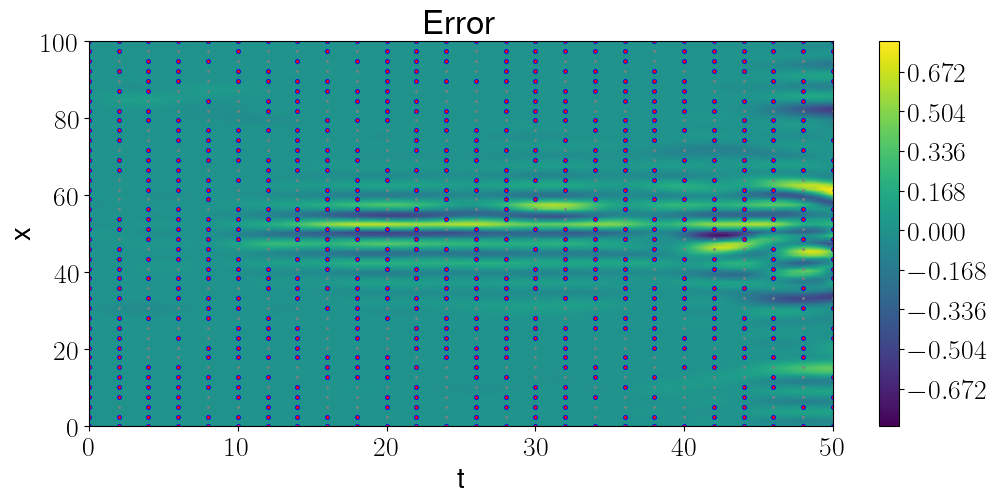

In [279]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,t_range[1],num_fine_grid),np.linspace(0,x_range[1],num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)

u_true_fine = u_true_function(tx_grid_fine)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Learned u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_eval_fine,200)
plt.colorbar()
plt.subplot(1,3,2)
plt.title("Initial u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_model.point_evaluate(tx_grid_fine,u_params_init),200)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine,200)
plt.colorbar()

plt.show()
plt.figure(figsize = (12,5))
plt.title("Error")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine-u_eval_fine,250)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],c='gray',s = 1)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='blue',s = 6)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 2,marker = 'x')


plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [280]:
# 1 step error
jnp.linalg.norm(u_model.point_evaluate(tx_grid_fine,u_sol)-u_true_fine)/jnp.linalg.norm(u_true_fine)

Array(0.1525441, dtype=float64)

In [281]:
jnp.linalg.norm(u_model.point_evaluate(tx_grid_fine,u_params_init)-u_true_fine)/jnp.linalg.norm(u_true_fine)

Array(0.15394101, dtype=float64)

In [ ]:
from Optimizers import SketchedCGLM, SketchedCGLMParams
params_init = jnp.hstack([u_params_init,jnp.zeros(len(tx_int))])
optparams = SketchedCGLMParams(max_iter = 1001,random_key = jax.random.PRNGKey(310),sketch_size=200)

params,cg_convergence = SketchedCGLM(
    params_init.copy(),
    EqnModel,
    beta = 0.,
    optParams = optparams
    )

In [180]:
dir(EqnModel)

['F',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'apply_rhs_op_single',
 'collocation_points',
 'damping_matrix',
 'datafit_residual_single',
 'datafit_weight',
 'equation_residual_single',
 'feature_operators',
 'get_P_params',
 'get_u_params',
 'jac',
 'jacobian_operator',
 'loss',
 'num_operator_params',
 'observation_points',
 'observation_values',
 'operator_model',
 'operator_model_indices',
 'residual_dimension',
 'rhs_forcing_values',
 'rhs_operator',
 'single_eqn_features',
 'stacked_collocation_rhs',
 'stacked_datafit_residual',
 'stacked_equation_residual',
 'stacked_observation_values',
 'total_parameters',
 'u_indexing',
 'u_models']